In [34]:
# Import packages
import os
import pathlib
import zipfile

import geopandas as gpd
from load_plot_model import load_dtm, plot_model, plot_hists, run_rem_maker, run_rem_maker_lidar, get_uav_dtms
import matplotlib.pyplot as plt
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr
from rioxarray.merge import merge_arrays

ImportError: cannot import name 'get_uav_dtms' from 'load_plot_model' (/Users/lchipman/earth-analytics/watershed-project/load_plot_model.py)

In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'watershed-project')

# Try/Except Block   
try:
    os.chdir(working_dir)
except:
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
else:
    print('{} is now the working directory'.format(working_dir))

/Users/lchipman/earth-analytics/data/watershed-project is now the working directory


## Download and unzip lidar
ideally would download from CO hs site, but there is no direct link. I uploaded zip files to git, and had to change the file content names bc otherwise  running into issues unzipping - the extracted files include root directory in filename, and the name is not callable

In [3]:
# Function to create dictionary to store info for lidar download
def get_lidar_url(site_names):
    """
    Creates a dictionary to store info for lidar download
    
    Parameters
    -------------
    site_names: list
        List of the site names.
    
    Returns
    ------------
    site_lidar_urls: list
        List of dictionaries with sitename, lidar url, and zip filename.
    
    """
    #lidar_url = ('https://github.com/lechipman/watershed-project/'
     #                'releases/download/v2.0.0/{}_lidar.zip'.format(site_name))
    site_lidar_urls = []
    for site_name in site_names:
        site_lidar_urls.append({
            'site_name': site_name,
            'lidar_url': ('https://github.com/lechipman/'
                          'watershed-project/releases/download/v2.0.0/'
                          '{}_lidar.zip'.format(site_name)),
            'zip_filename': ('{}_lidar.zip'.format(site_name))
    })
    return site_lidar_urls

In [4]:
# Call the function to create dictionaries for the sites.
site_names = ['applevalley', 'hallmeadows', 'hallmeadows2', 'highway93']
site_lidar_urls = get_lidar_url(site_names=site_names)

In [5]:
# Save the lidar DTMs to the dictionaries
for site in site_lidar_urls:
    site['lidar_dtm'] = load_dtm(data_url=site['lidar_url'], 
                                     site_name=site['site_name'],
                                     file_name=site['zip_filename'])
# Merge the 2 hallmeadows tiles and replace dtm:
for site in site_lidar_urls:
    if site['site_name'] == 'hallmeadows':
        site['lidar_dtm'] = (merge_arrays(dataarrays = [site_lidar_urls[1]['lidar_dtm'], 
                                                        site_lidar_urls[2]['lidar_dtm']]))
    if site['site_name'] == 'hallmeadows2':
        site_lidar_urls.remove(site)

## Plot the LiDAR DTMs

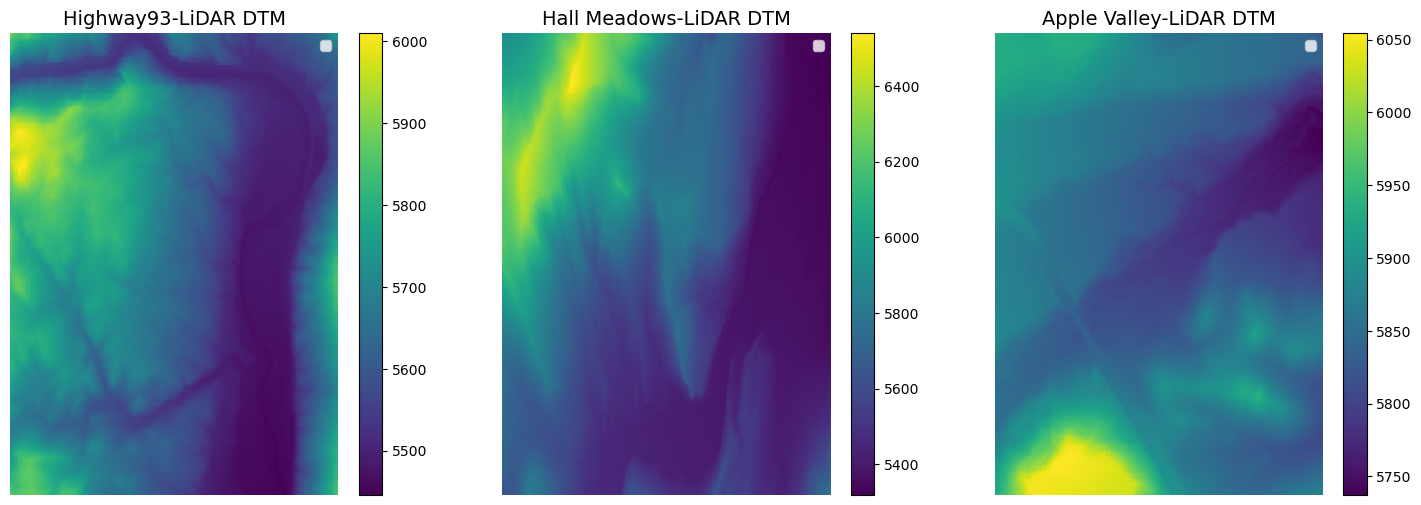

In [8]:
# Call function to plot Lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Highway93-LiDAR DTM', 
              'Hall Meadows-LiDAR DTM',
              'Apple Valley-LiDAR DTM']

for i, axe in enumerate(axes.flatten()):
    plot_model(model=site_lidar_urls[i]['lidar_dtm'], 
               title=plot_title[i],
               coarsen=(True),
               xpix=10, 
               ypix=10,
               ax=axe)

## Clip the lidar DTMs

In [35]:
def boundary_gdf(data_url, site_name):
    """Downloads boundary shapefiles and open as a gdf
    
    Parameters
    ------------
    data_url: str
        Url for the boundary shapefiles (zipfile)
    
    site_name: str
        The site name.
        
    Returns
    ------------
    gdf: geodataframe
        A geodataframe containing the boundary geometry.
    """
    override_cache = False
    data_dir='shapefiles'
    data_path = os.path.join('shapefiles.zip')
    
    # Cache data file
    if (not os.path.exists(data_path)) or override_cache:
        print('{} does not exist. Downloading...'.format(data_path))
        # Download full data file as zipfile
        response = requests.get(data_url)

        # Write in respose content using context manager
        with open(data_path, 'wb') as data_file:
            data_file.write(response.content)
            
    with zipfile.ZipFile(data_path, 'r') as shape_zipfile:
        shape_zipfile.extractall(working_dir)
    data_path=os.path.join(data_dir,
                           '{}_bounding_polygon'.format(site_name),
                           'Bounding_Polygon.shp')

    # Open the bounding polygon as gdf
    try:
        gdf = gpd.read_file(data_path)
        return gdf
    except:
        print('There is no bounding polygon for the {} site, ' 
              'skipping this site'.format(site_name))

In [36]:
# Call function to create bounding polygon gdf for each site, save to site_lidar_urls
shape_url = ('https://github.com/lechipman/watershed-project/'
                 'releases/download/v2.0.0/shapefiles.zip')

for site in site_lidar_urls:
    site['bounding_polygon'] = (get_boundary_gdf(
                                data_url=shape_url, 
                                site_name=site['site_name']))

shapefiles/applevalley_bounding_polygon/Bounding_Polygon.shp
shapefiles/hallmeadows_bounding_polygon/Bounding_Polygon.shp
shapefiles/highway93_bounding_polygon/Bounding_Polygon.shp


In [37]:
# Function for opening and clipping the geotiff file
def lidar_clip(site_name, lidar_dtm, clip_gdf):
    """
  Clips and reprojects the lidar raster to the area of interest (AOI)
  using a supplied shapefile.

  Parameters
  ----------
  lidar_dtm: DataArray
      The dtm to clip.
  clip_gdf: Geodataframe
      GDF of the AOI.

  Returns
  -------
  clipped_dtm = DataArray
      The preprocessed raster dataset.
  """
    raster_path=os.path.join('{}'.format(site_name), '{}_lidar_dtm.tif'.format(site_name))
    reproject_dtm = lidar_dtm.rio.reproject("EPSG:4326")
    clipped_dtm = (reproject_dtm
                  .squeeze()
                  .rio.clip(clip_gdf.geometry, crs=clip_gdf.crs))
    # Save the clipped lidar dtm as raster for use in RiverREM
    clipped_dtm.rio.to_raster(raster_path)
    
    return clipped_dtm

In [38]:
# Clip the lidar dtm to bounding polygon and add to dictionary
for site in site_lidar_urls:
    site['lidar_clipped_dtm'] = lidar_clip(site_name = site['site_name'],
                                           lidar_dtm = site['lidar_dtm'],
                                           clip_gdf = site['bounding_polygon'])

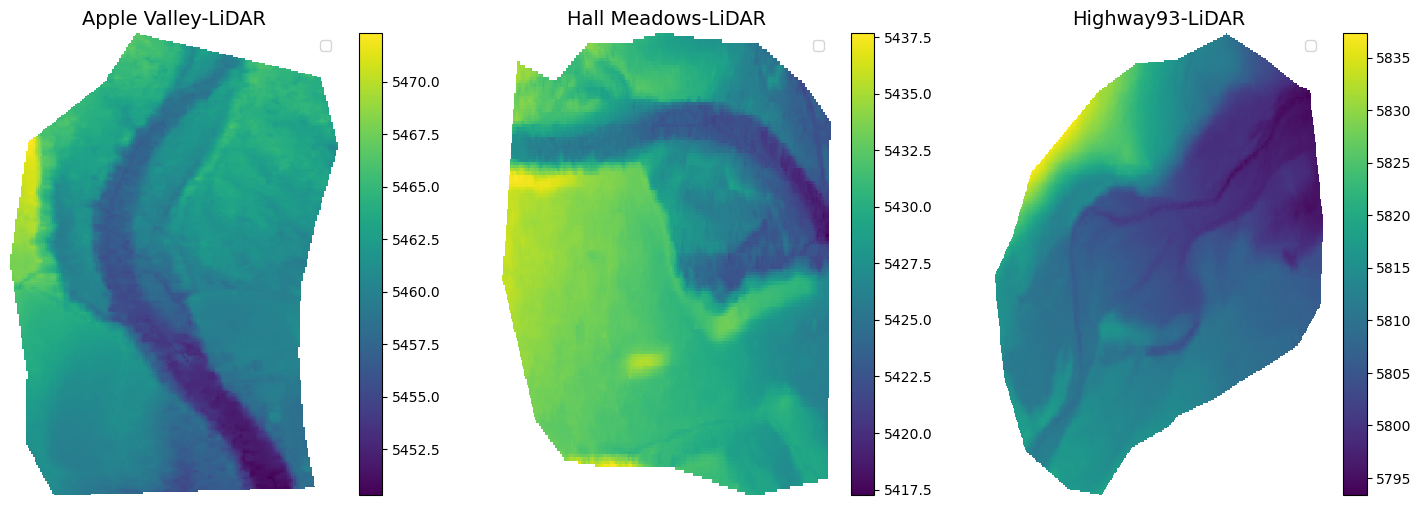

In [39]:
# Call function to plot lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley-LiDAR', 
              'Hall Meadows-LiDAR',
              'Highway93-LiDAR']
for i, axe in enumerate(axes.flatten()):
    plot_model(model=site_lidar_urls[i]['lidar_clipped_dtm'], 
               title=plot_title[i],
               coarsen=(False),
               ax=axe)

## To do for steps above

Speeding up plots/reducing file size? - pickling??

# Load the UAV DTMs and REMs

In [13]:
site_data_dictionary = get_uav_dtms(site_data_dictionary=site_lidar_urls)

applevalley/applevalley_dtm.tif does not exist. Downloading...


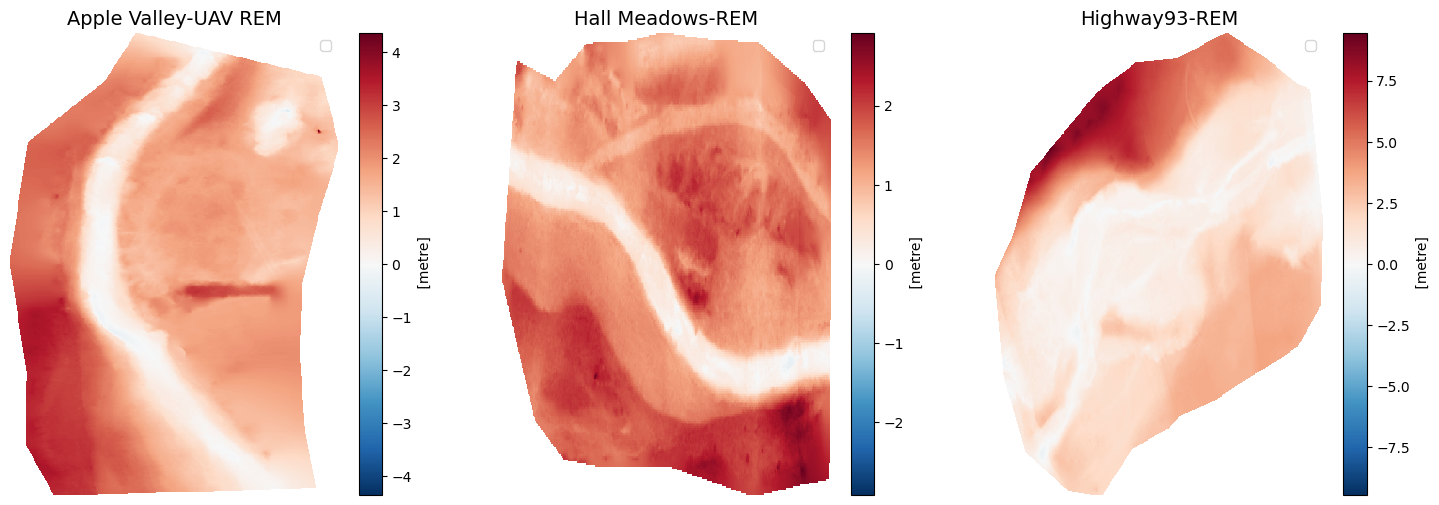

In [16]:
# Call function to plot lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley-UAV REM', 
              'Hall Meadows-REM',
              'Highway93-REM']
for i,axe in enumerate(axes.flatten()):
    plot_model(model=site_data_dictionary[i]['uav_rem'], 
                   title=plot_title[i],
                   coarsen=True,
                   xpix=20,
                   ypix=20,
                   ax=axe)

## LiDAR and UAV DTM histograms

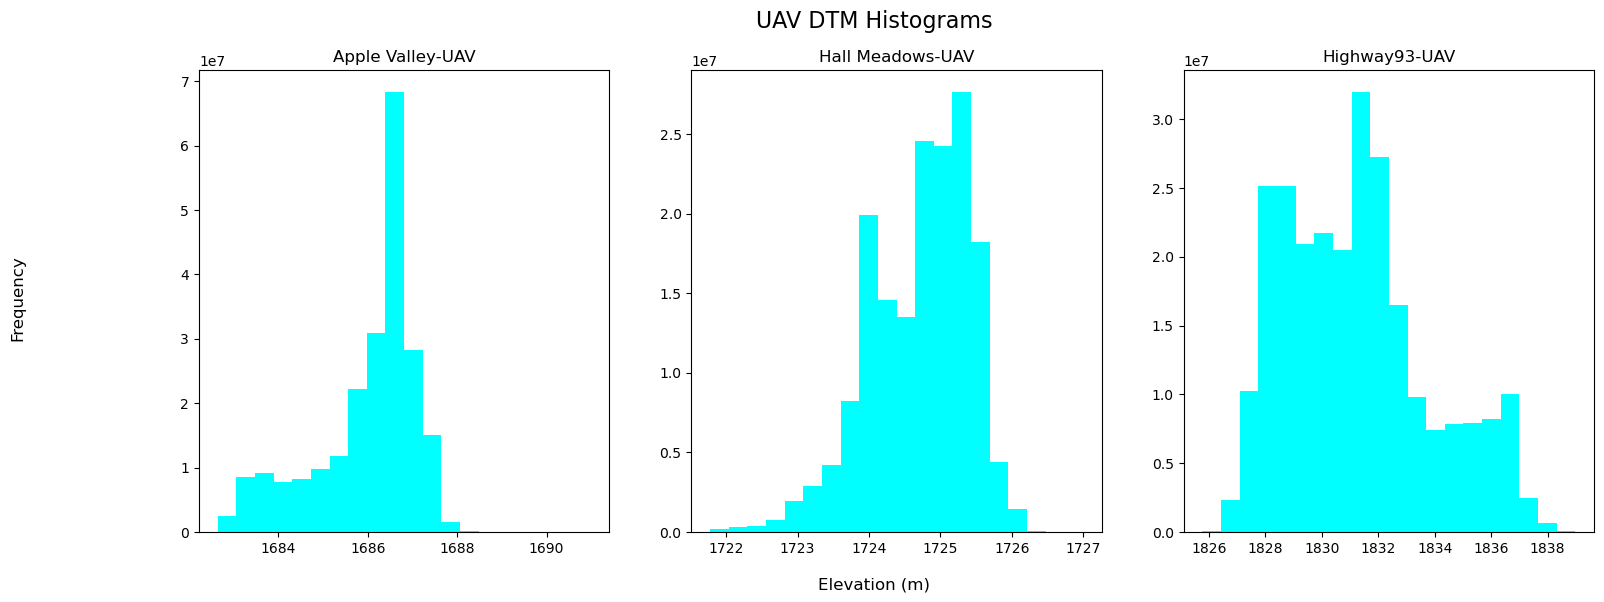

In [19]:
# Call function to plot histogram of lidar and UAV DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    plot_hists(model=site_data_dictionary[i]['uav_dtm'], 
               titles=plot_title[i],
               main_title='UAV DTM Histograms',
               color=('cyan'),
               fig=fig,
               ax=axe)

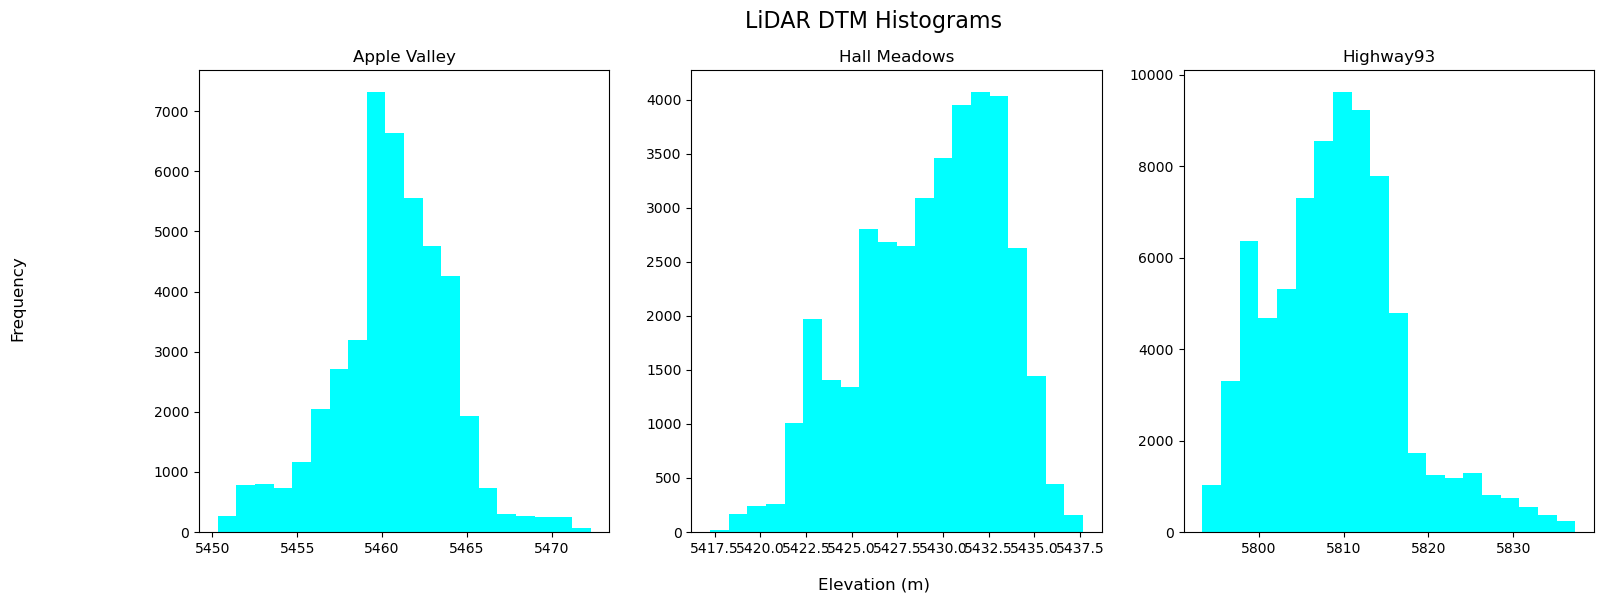

In [22]:
# Call function to plot histogram of lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    plot_hists(model=site_data_dictionary[i]['lidar_clipped_dtm'], 
               titles=plot_title[i],
               main_title='LiDAR DTM Histograms',
               color=('cyan'),
               fig=fig,
               ax=axe)

# Create LiDAR REMs Using REMMaker Tool

In [65]:
# Create LiDAR REMs for all sites with run_rem_maker function, add to dict
for site in site_data_dictionary:
    run_rem_maker_lidar(site_name=site['site_name'])
    lidar_rem_path = os.path.join(site['site_name'],
                                  'remmaker_lidar',
                                  '{}_lidar_dtm_REM.tif').format(site['site_name'])
    site['lidar_remmaker'] = rxr.open_rasterio(lidar_rem_path, masked=True)

The LiDAR REMMaker REM already exists. Not running REMMaker
The LiDAR REMMaker REM already exists. Not running REMMaker
The LiDAR REMMaker REM already exists. Not running REMMaker


## Create UAV REMs Using REMMaker Tool

In [33]:
for site in site_data_dictionary:
    run_rem_maker(site_name=site['site_name'], k=100)
    uav_rem_path = os.path.join(site['site_name'],
                                  'remmaker',
                                  '{}_dtm_REM.tif').format(site['site_name'])
    site['uav_remmaker'] = rxr.open_rasterio(uav_rem_path, masked=True)

The REM already exists. Not running REMMaker
The REM already exists. Not running REMMaker
The REM already exists. Not running REMMaker


# Plot the UAV and LiDAR Derived REMs

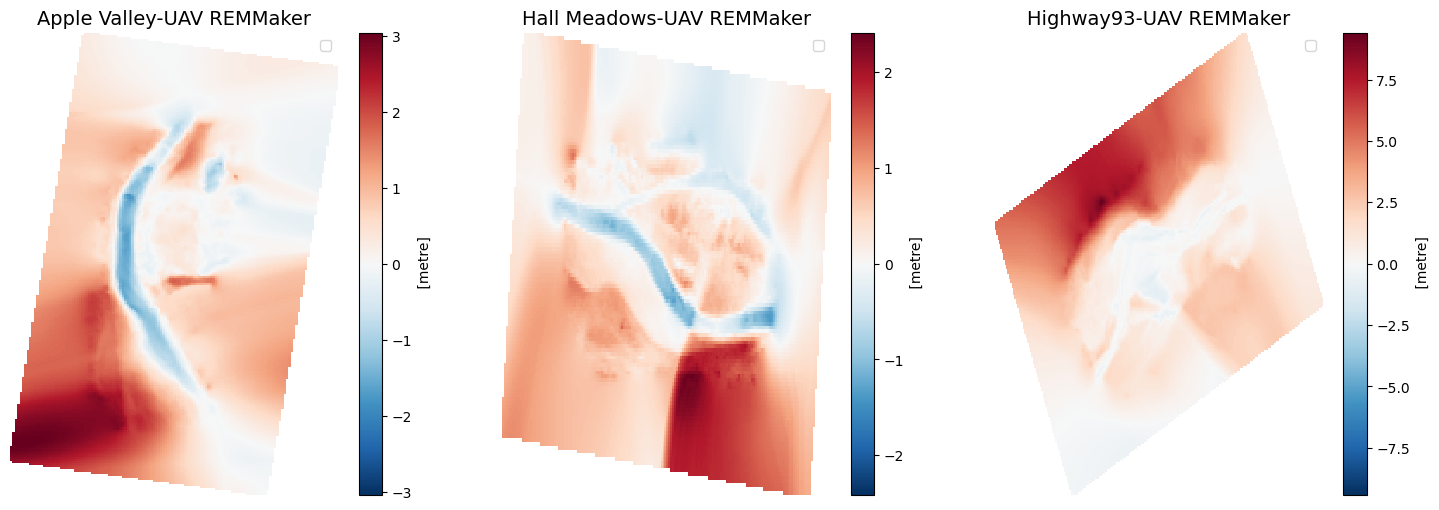

In [45]:
# Call function to plot UAV REMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley-UAV REMMaker', 
              'Hall Meadows-UAV REMMaker',
              'Highway93-UAV REMMaker']
for i,axe in enumerate(axes.flatten()):
    plot_model(model=site_data_dictionary[i]['uav_remmaker'], 
                   title=plot_title[i],
                   coarsen=True,
                   xpix=100,
                   ypix=100,
                   ax=axe)

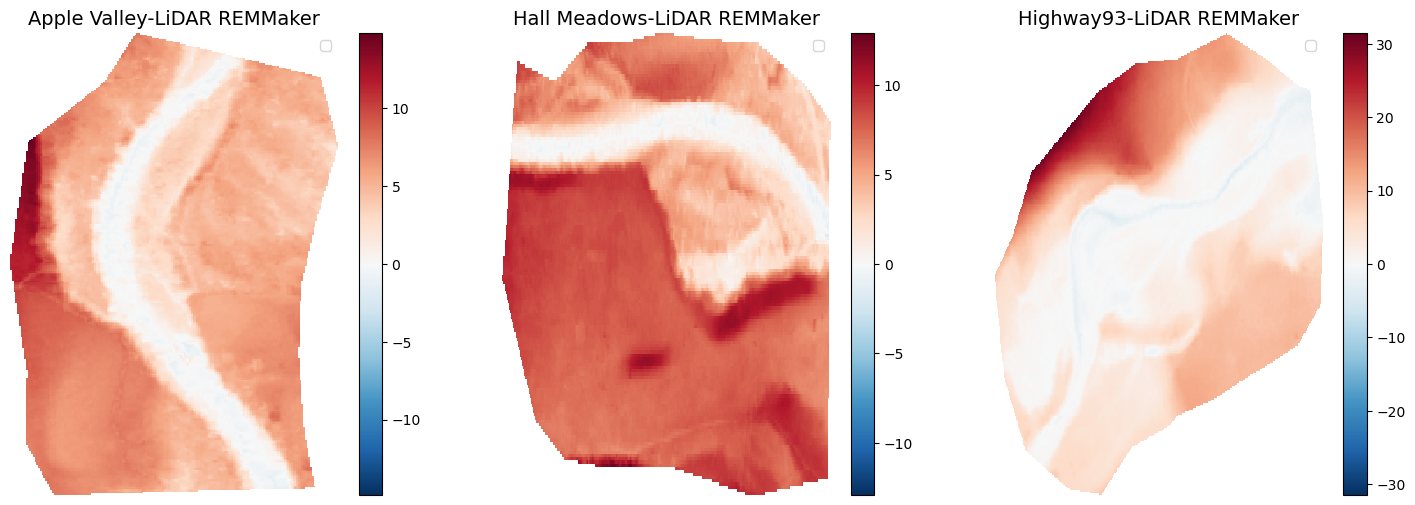

In [46]:
# Call function to plot lidar REMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley-LiDAR REMMaker', 
              'Hall Meadows-LiDAR REMMaker',
              'Highway93-LiDAR REMMaker']
for i,axe in enumerate(axes.flatten()):
    plot_model(model=site_data_dictionary[i]['lidar_remmaker'], 
                   title=plot_title[i],
                   coarsen=False,
                   #xpix=100,
                   #ypix=100,
                   ax=axe)

## LiDAR and UAV REMMaker Histograms

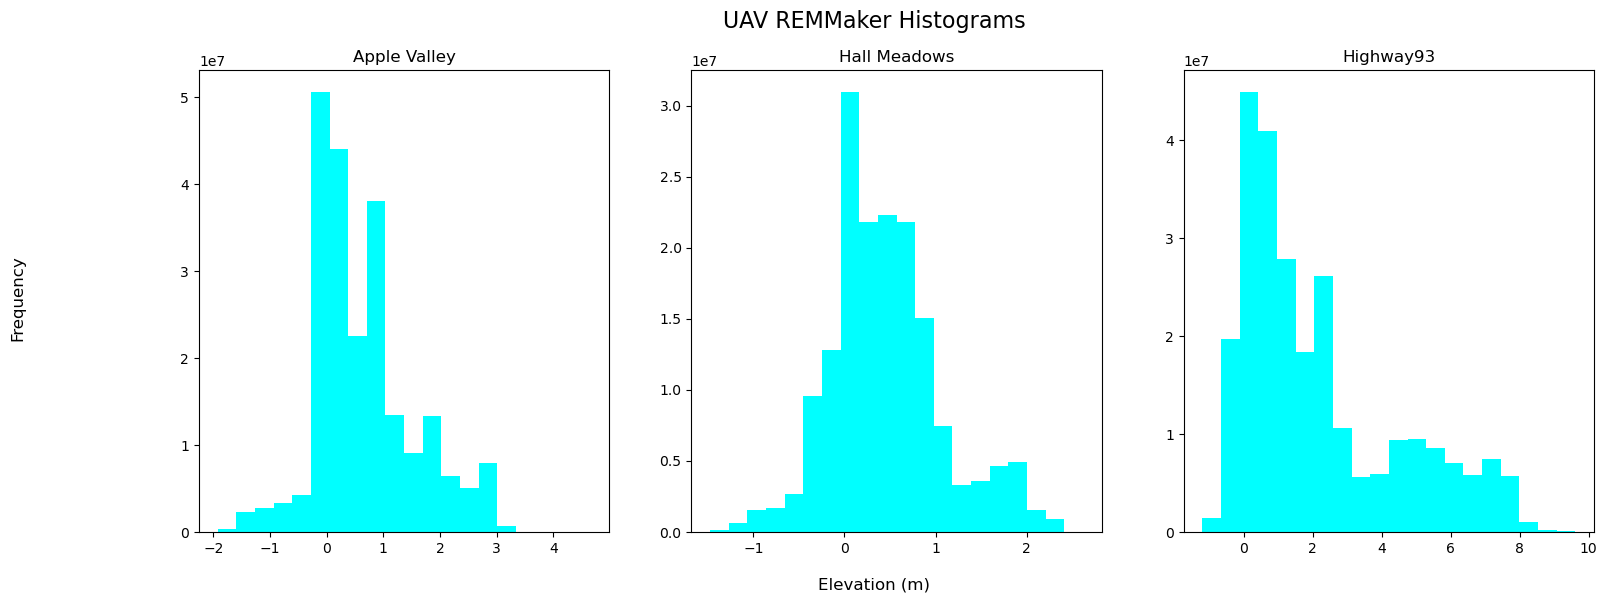

In [47]:
# Call function to plot histogram of UAV REMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    plot_hists(model=site_data_dictionary[i]['uav_remmaker'], 
               titles=plot_title[i],
               main_title='UAV REMMaker Histograms',
               color=('cyan'),
               fig=fig,
               ax=axe)

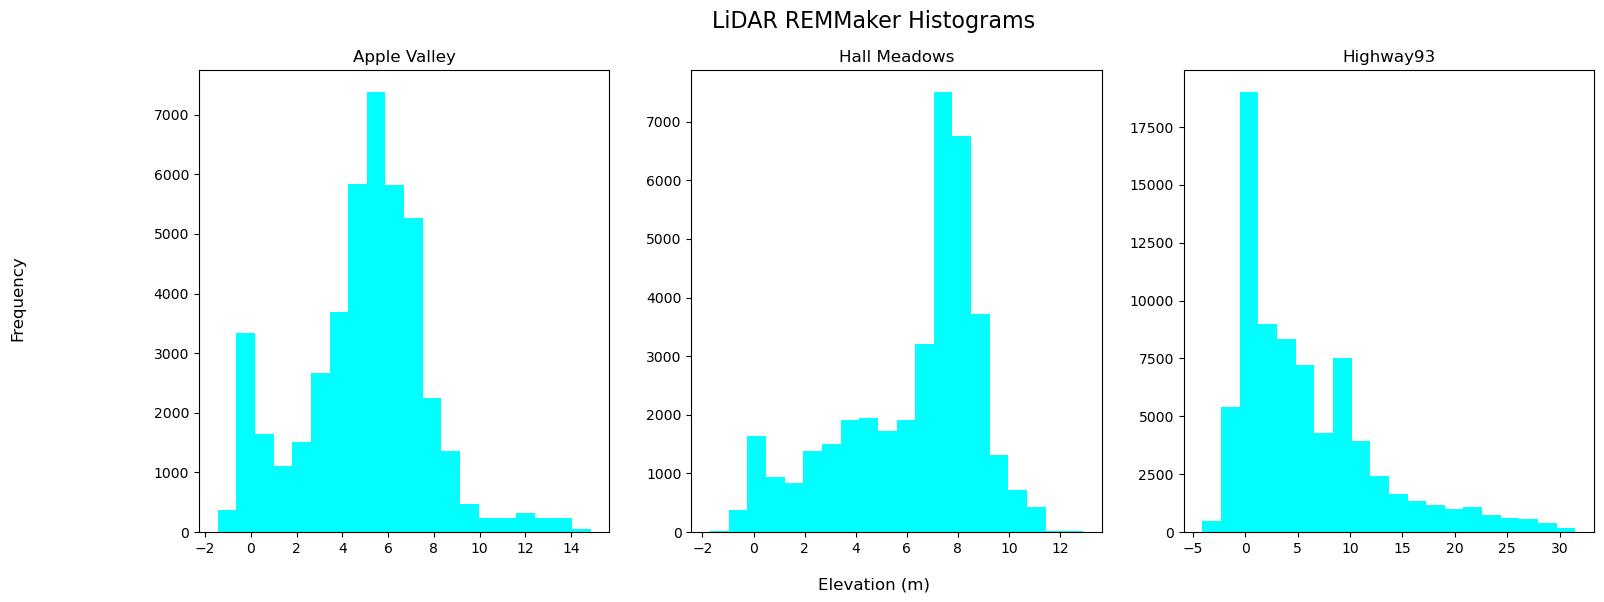

In [48]:
# Call function to plot histogram of lidar REMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    plot_hists(model=site_data_dictionary[i]['lidar_remmaker'], 
               titles=plot_title[i],
               main_title='LiDAR REMMaker Histograms',
               color=('cyan'),
               fig=fig,
               ax=axe)

## Flood mapping
* set a threshold value that represents flooding level (e.g., anything less than 3ft will be innundated)
* for both the uav and lidar rems, calculate the sum of the #points that are <threshold, and multiply by pixel size - this represents the area flooded
* can loop through several flood levels and compare uav/lidar with a scatter plot of flooded area

In [63]:
# Calculate difference in REMs - need to match resolution
#for site in site_data_dictionary:
#    site['dod_array'] = site['uav_remmaker'] - site['lidar_remmaker']
site_data_dictionary[0]['uav_remmaker']

<xarray.DataArray (band: 1, y: 22019, x: 13873)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
  * y            (y) float64 40.24 40.24 40.24 40.24 ... 40.24 40.24 40.24 40.24
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        4.65869140625
    STATISTICS_MEAN:           0.64758001010875
    STATISTICS_MINIMUM:        -1.9224853515625
    STATISTICS_STDDEV:         0.88402427491501
    STATISTICS_VALID_PERCENT:  73.41
    scale_factor:              1.0
    add_offset:                0.0
    units:                     metre

In [64]:
threshhold_das = []
site_data_dictionary[0]['uav_remmaker'].where(site_data_dictionary[0]['uav_remmaker'] < 3)

<xarray.DataArray (band: 1, y: 22019, x: 13873)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
  * y            (y) float64 40.24 40.24 40.24 40.24 ... 40.24 40.24 40.24 40.24
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        4.65869140625
    STATISTICS_MEAN:           0.64758001010875
    STATISTICS_MINIMUM:        -1.9224853515625
    STATISTICS_STDDEV:         0.88402427491501
    STATISTICS_VALID_PERCENT:  73.41
    scale_factor:              1.0
    add_offset:                0.0
    units:                     metre